In [244]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = "Times New Roman"

In [245]:
stai_scores = np.array(pd.read_csv(r'stai_scores.csv', header=None)[0])
inst_choices = np.array(pd.read_csv(r'inst_choices.csv', header=None))
inst_outcomes = np.array(pd.read_csv(r'inst_outcomes.csv', header=None))

### Data exploration

In [246]:
# Exploring the data: mean, median, standard deviation of STAI
overall_mean = np.mean(stai_scores); print(overall_mean)
overall_std = np.std(stai_scores); print(overall_std)
overall_median = np.median(stai_scores); print(overall_median)

anxious_mean = np.mean(stai_scores[0:25]); print(anxious_mean)
anxious_std = np.std(stai_scores[0:25]); print(anxious_std)
anxious_median = np.median(stai_scores[0:25]); print(anxious_median)

control_mean = np.mean(stai_scores[25:]); print(control_mean)
control_std = np.std(stai_scores[25:]); print(control_std)
control_median = np.median(stai_scores[25:]); print(control_median)
print(sp.stats.ttest_ind(stai_scores[:25], stai_scores[25:], equal_var=False))

42.72
14.730974170094793
40.0
55.24
9.84390166549829
57.0
30.2
4.857983120596448
29.0
Ttest_indResult(statistic=11.174860157303042, pvalue=4.2293214098115444e-13)


In [247]:
# Exploring the data: cut-off = 43, ANXIOUS group if STAI>43
cut_off_stai = np.zeros(len(stai_scores))
for i in range(len(stai_scores)):
    if stai_scores[i] <= 43:
        # cut_off_stai = 1 if the subject is in the healthy control group
        cut_off_stai[i] = 1

healthy_num = sum(cut_off_stai)
healthy_index = np.where(cut_off_stai==1)
print(healthy_num)
print(healthy_index)

29.0
(array([ 3, 15, 16, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)


In [248]:
# Exploring the data: number of times each subject choosing stimuli A
chose_a_count = []
chose_a_percent = []
for i in range(len(inst_choices)):
    chose_a_count.append(np.array(np.where(inst_choices[i]==1)).size)
    chose_a_percent.append(chose_a_count[-1]/len(inst_choices[i]))
print(chose_a_count)
print(chose_a_percent)
print(np.average(chose_a_count))

[52, 46, 32, 58, 37, 26, 28, 50, 38, 51, 53, 30, 31, 41, 36, 33, 41, 41, 28, 37, 53, 33, 40, 67, 31, 45, 29, 6, 25, 7, 12, 29, 21, 29, 16, 36, 39, 27, 41, 25, 39, 28, 29, 36, 45, 24, 16, 53, 31, 22]
[0.325, 0.2875, 0.2, 0.3625, 0.23125, 0.1625, 0.175, 0.3125, 0.2375, 0.31875, 0.33125, 0.1875, 0.19375, 0.25625, 0.225, 0.20625, 0.25625, 0.25625, 0.175, 0.23125, 0.33125, 0.20625, 0.25, 0.41875, 0.19375, 0.28125, 0.18125, 0.0375, 0.15625, 0.04375, 0.075, 0.18125, 0.13125, 0.18125, 0.1, 0.225, 0.24375, 0.16875, 0.25625, 0.15625, 0.24375, 0.175, 0.18125, 0.225, 0.28125, 0.15, 0.1, 0.33125, 0.19375, 0.1375]
34.46


In [249]:
print(np.where(chose_a_count[0:25]<=np.average(chose_a_count)))
print(np.where(chose_a_count[25:]<=np.average(chose_a_count)))

(array([ 2,  5,  6, 11, 12, 15, 18, 21, 24]),)
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 14, 16, 17, 20, 21, 23, 24]),)


In [250]:
print(np.average(inst_outcomes))
print(np.average(np.average(inst_outcomes[:25],axis=1)))
print(np.average(np.average(inst_outcomes[25:],axis=1)))

0.384625
0.40275
0.3665


### Simulation


In [251]:
# Value of a chosen stimuli i at time t, and the overall outcome
# the probability of each stimulus to lead to the aversive noise, 70/30, 80/20, 60/40, 65/35 (A/B)
# A reinforcement learning model, the Rescorla-Wagner model, to update the subjective value
# of A and B after each trial. The value of A and B at trial i+1 is updated based on
# the prediction error of the chosen option at trial i. This means that
# if the outcome is better than expected, the subjective value of the chosen option is increased, and 
# if the outcome is worse than expected, the subjective value of the chosen option is decreased. 
# This model assumes that the subjective value of an option is updated in response to feedback.
np.random.seed(1)
prob_list = [[0.3,0.7],[0.2,0.8],[0.4,0.6],[0.35,0.65]]

def outcome(a,b,p,V0):
    
    outcome = np.zeros(160)
    choice = []
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice.append(np.random.choice([0,1],p=[p_a,p_b]))
        if choice[-1] == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, choice, value_a, value_b, sum(outcome)


# if correct, 'np.mean(test)' should be around 58
test = []
for i in range(1000):
    test.append(outcome(0.4,7,prob_list,0.5)[-1])
np.mean(test)

58.124

In [252]:
# Simulation: a = 0.4, b = 7, V0 = 0.5
# Average out the outcome for 10000 trials
np.random.seed(1)
n = 10000
value_a = np.zeros([n,161])
value_b = np.zeros([n,161])
for i in range(n):
    value_a[i] = outcome(0.4,7,prob_list,0.5)[2]
    value_b[i] = outcome(0.4,7,prob_list,0.5)[3]
value_a = np.mean(value_a,axis=0)
value_b = np.mean(value_b,axis=0)


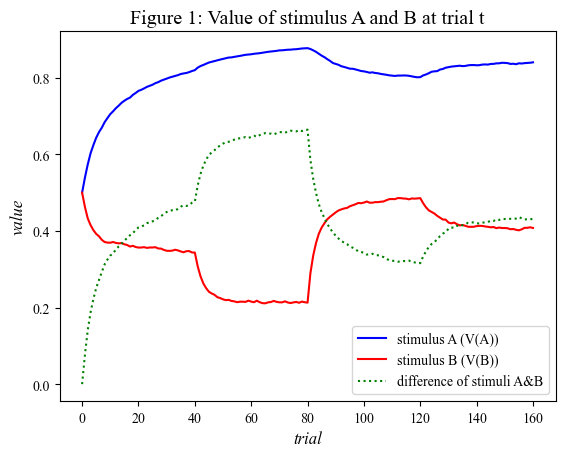

In [253]:
plt.title('Figure 1: Value of stimulus A and B at trial t', fontsize = 'x-large')
plt.plot(value_a, color = 'b', label = "stimulus A (V(A))")
plt.plot(value_b, color = 'r', label = "stimulus B (V(B))")
plt.plot(np.array(value_a)-np.array(value_b), color = 'g', linestyle = 'dotted', label = "difference of stimuli A&B")
plt.xlabel('trial', fontsize = 'large', fontstyle = 'italic')
plt.ylabel('value', fontsize = 'large', fontstyle = 'italic')
plt.legend(loc='lower right')

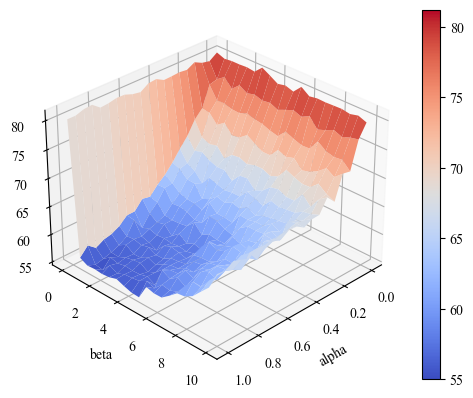

In [254]:
# Plot the average number of aversive stimuli received as a function of the parameter settings
# alpha determines the rate of learning, with higher values leading to faster learning. 
# beta determines the sensitivity to reward prediction errors, with higher values leading 
# to greater sensitivity. Thus, a higher alpha value may lead to faster adaptation to changes 
# in the environment, while a higher beta value may lead to more cautious behavior and fewer 
# aversive outcomes. However, there may be trade-offs between these parameters, as increasing 
# one parameter may negatively affect performance if the other parameter is not also adjusted appropriately. 

np.random.seed(1)
num = 20
n = 100
sim_mat = np.zeros([num,num])
alpha = (np.linspace(0,1,num))
beta = (np.linspace(0,10,num))
for i in range(num):
    for j in range(num):
        sim = np.zeros(n)
        for k in range (n):
            sim[k] = outcome(alpha[i],beta[j],prob_list,0.5)[-1]
        sim_mat[i][j] = np.mean(sim)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)
X, Y = np.meshgrid(alpha, beta)
plot = ax.plot_surface(X, Y, sim_mat, cmap='coolwarm', vmin=np.min(sim_mat), vmax=np.max(sim_mat))
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('avg aversive stimuli')
fig.colorbar(plot)

plt.show()

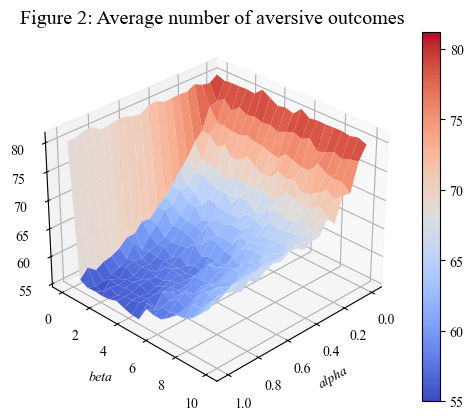

In [255]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)
X, Y = np.meshgrid(alpha, beta)
plot = ax.plot_surface(X, Y, sim_mat, cmap='coolwarm', vmin=np.min(sim_mat), vmax=np.max(sim_mat))
ax.set_xlabel('alpha',fontstyle = 'italic')
ax.set_ylabel('beta',fontstyle = 'italic')
ax.set_title('Figure 2: Average number of aversive outcomes',fontsize = 'x-large')
fig.colorbar(plot)

plt.show()

### Likelihood function

In [256]:
# a function that takes as input the data (choices and outcomes) for an 
# individual and a vector of parameters (learning rate and inverse temperature) 
# and returns the negative log likelihood (NLL)

def nll(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    a, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll

## test should be around 61 
test = nll([0.4,7],inst_choices[8],inst_outcomes[8],0.5); print(test)
nll4 = nll([0.4,7],inst_choices[3],inst_outcomes[3],0.5); print(nll4)
nll5 = nll([0.4,7],inst_choices[4],inst_outcomes[4],0.5); print(nll5)


60.877333438783324
101.6050206224349
52.68861467295329


### Model fitting

In [257]:
# Find the parameters that minimize the NLL for each individual, passing the NLL 
# function and a set of starting parameters (alpha = 0.4 and beta = 7) to a 
# optimization function performing unconstrained minimization.
# Use the the Nelder-Mead algorithm from scipy.optimize

fitted_param = []
for i in range(len(stai_scores)):
    fitted_param.append(sp.optimize.minimize(nll,x0=(0.4,7), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead').x)

In [258]:
# Calculate the mean and variance of the fitted parameter values for learning rate and inverse temperature
# Also, obtain the Pearson’s correlation coefficient between estimated parameters
# Then, taking the first 25 participants as the high anxious group, calculate the Pearson’s correlation 
# coefficient between estimated parameters separately for participants within each group.

fitted_alpha, fitted_beta = np.array(fitted_param).T

mean_alpha = np.mean(fitted_alpha); print(mean_alpha)
var_alpha = np.var(fitted_alpha); print(var_alpha)
mean_beta = np.mean(fitted_beta); print(mean_beta)
var_beta = np.var(fitted_beta); print(var_beta)

mean_alpha_anxious = np.mean(fitted_alpha[:25]); print(mean_alpha_anxious)
mean_alpha_control = np.mean(fitted_alpha[25:]); print(mean_alpha_control)
mean_beta_anxious = np.mean(fitted_beta[:25]); print(mean_beta_anxious)
mean_beta_control = np.mean(fitted_beta[25:]); print(mean_beta_control)

print(sp.stats.pearsonr(fitted_alpha, fitted_beta))
print(sp.stats.pearsonr(fitted_alpha[:25], fitted_beta[:25]))
print(sp.stats.pearsonr(fitted_alpha[25:], fitted_beta[25:]))

0.4758865798481678
0.028823177110009483
5.165364859938008
2.7646122988261386
0.5874739980369317
0.36429916165940396
4.655724358126161
5.6750053617498555
PearsonRResult(statistic=-0.2369656492300812, pvalue=0.09753716137988659)
PearsonRResult(statistic=-0.46745261030155233, pvalue=0.01846598704926908)
PearsonRResult(statistic=0.40900638521961774, pvalue=0.04234454107340218)


In [259]:
np.where(fitted_beta>10)

(array([27]),)

Text(0.5, 1.0, 'beta')

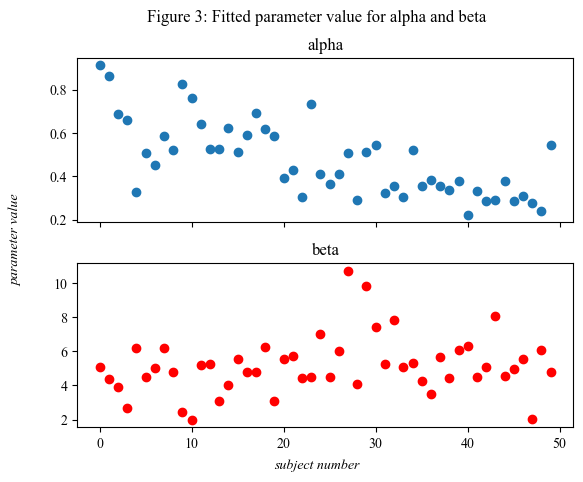

In [260]:
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Figure 3: Fitted parameter value for alpha and beta')
fig.text(0.5, 0.03, 'subject number', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha)
ax[0].set_title('alpha')
ax[1].scatter(np.arange(0,50,1),fitted_beta, color = 'red')
ax[1].set_title('beta')

### Group comparison

In [261]:
# If the data was real and we obtained a significant result, we might conclude that 
# there is a meaningful difference between the parameter values for the two groups. 
# This could support our hypothesis that high anxiety is associated with differences 
# in decision-making processes.

dof = len(fitted_alpha[:25]) + len(fitted_alpha[25:]) - 2; print(dof)
print(sp.stats.ttest_ind(fitted_alpha[:25], fitted_alpha[25:], equal_var=False))
print(sp.stats.ttest_ind(fitted_beta[:25], fitted_beta[25:], equal_var=False))

48
Ttest_indResult(statistic=6.042165319443778, pvalue=4.539257722057438e-07)
Ttest_indResult(statistic=-2.2309569492149133, pvalue=0.031110531474266866)


### Parameter recovery

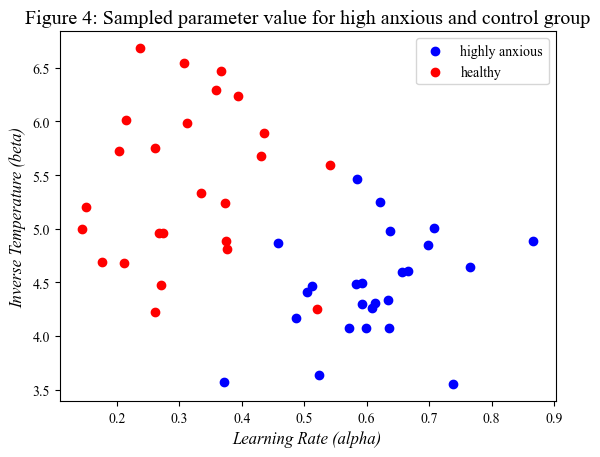

In [262]:
# Sample 50 sets of parameter values of learning rate and inverse temperature from a multivariate normal distributions

def gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control):
    var_learning_rate = 0.01
    var_inv_temp = 0.5
    cov = 0

    # anxious group
    mean = [mean_alpha_anxious, mean_beta_anxious]
    covariance = [[var_learning_rate, cov], [cov, var_inv_temp]]
    param_values = np.random.multivariate_normal(mean, covariance, 25)

    min_learning_rate = 0
    max_learning_rate = 1
    min_inv_temp = 0
    max_inv_temp = 10

    while True:
        invalid_indices = np.where((param_values[:, 0] < min_learning_rate) | 
                                (param_values[:, 0] > max_learning_rate) | 
                                (param_values[:, 1] < min_inv_temp) |
                                (param_values[:, 1] > max_inv_temp))[0]
        if len(invalid_indices) == 0:
            break
        param_values[invalid_indices] = np.random.multivariate_normal(mean, covariance, len(invalid_indices))


    # control group
    mean = [mean_alpha_control, mean_beta_control]
    covariance = [[var_learning_rate, cov], [cov, var_inv_temp]]
    param_values_c = np.random.multivariate_normal(mean, covariance, 25)

    while True:
        invalid_indices = np.where((param_values_c[:, 0] < min_learning_rate) | 
                                (param_values_c[:, 0] > max_learning_rate) | 
                                (param_values_c[:, 1] < min_inv_temp) |
                                (param_values_c[:, 1] > max_inv_temp))[0]
        if len(invalid_indices) == 0:
            break
        param_values_c[invalid_indices] = np.random.multivariate_normal(mean, covariance, len(invalid_indices))

    return np.concatenate((param_values, param_values_c))

param_values = gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control)

plt.title('Figure 4: Sampled parameter value for high anxious and control group', fontsize = 'x-large')
plt.scatter(param_values[:25, 0], param_values[:25, 1],color = 'b', label = "highly anxious")
plt.scatter(param_values[25:, 0], param_values[25:, 1],color = 'r', label = "healthy")
plt.xlabel('Learning Rate (alpha)',fontsize = 'large', fontstyle = 'italic')
plt.ylabel('Inverse Temperature (beta)',fontsize = 'large', fontstyle = 'italic')
plt.legend(loc='upper right')

In [263]:
# Use the sampled parameter values to simulate 50 sets of data. 
# Fit new parameter values to these simulated data sets.
# Calculate the Pearson’s correlation between the parameter values used to
# simulate the data and the parameter values that you obtained from fitting 
# the model to the simulated data.

def param_sim(param_values):
    sim_choice = []
    sim_outcome = []
    for i in range(50):
        sim_choice.append((outcome(param_values[i][0],param_values[i][1],prob_list,0.5))[1])
        sim_outcome.append((outcome(param_values[i][0],param_values[i][1],prob_list,0.5))[0])

    fitted_param_1 = []
    for i in range(len(stai_scores)):
        fitted_param_1.append(sp.optimize.minimize(nll,x0=(param_values[i][0],param_values[i][1]), args=(sim_choice[i],sim_outcome[i],0.5),method='Nelder-Mead').x)

    fitted_alpha_1, fitted_beta_1 = np.array(fitted_param_1).T
    print(sp.stats.pearsonr(fitted_alpha_1, np.array(param_values).T[0]))
    print(sp.stats.pearsonr(fitted_beta_1, np.array(param_values).T[1]))

PearsonRResult(statistic=0.9999999999999998, pvalue=0.0)
PearsonRResult(statistic=0.9999999999999999, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=0.9999999999999997, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)
PearsonRResult(statistic=1.0, pvalue=0.0)


Text(0.5, 1.0, 'beta')

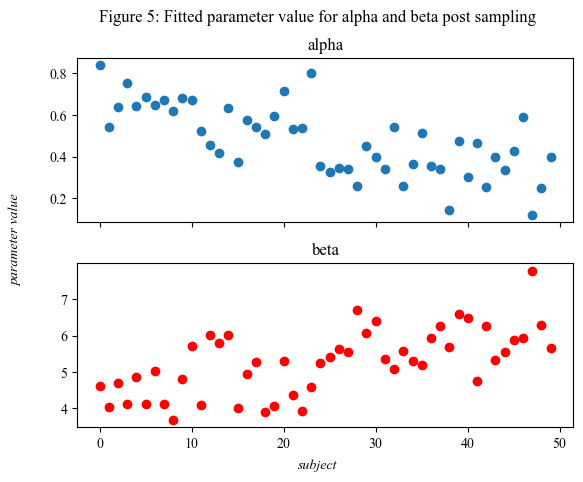

In [264]:
for i in range(5):
    param_values = gaussian(mean_alpha_anxious, mean_beta_anxious,mean_alpha_control, mean_beta_control)
    param_sim(param_values)

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Figure 5: Fitted parameter value for alpha and beta post sampling')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),np.array(param_values).T[0])
ax[0].set_title('alpha')
ax[1].scatter(np.arange(0,50,1),np.array(param_values).T[1], color = 'red')
ax[1].set_title('beta')

### Alternative model

In [265]:
# introduce a parameter, A
# Action selection for this model is again performed by the same softmax equation
# If A is close to 1, it means the person's choice heavily relies on the previous value V(t) 
# and does not update the value function significantly.
# If A is close to 0, it means the person's choice does not rely much on the previous value 
# V(t) and updates the value function mostly based on the prediction error o(t) - V(t).

def outcome_alt(A,a,b,p,V0):
    
    outcome = np.zeros(160)
    choice = []
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice.append(np.random.choice([0,1],p=[p_a,p_b]))
        if choice[-1] == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(A*value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(A*value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, choice, value_a, value_b, sum(outcome)

def nll_alt(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    A, a, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(A*value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(A*value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll

test_alt = []
for i in range(1000):
    test_alt.append(outcome_alt(0.5,0.4,5,prob_list,0.5)[-1])
print(np.mean(test_alt))

test_alt1 = nll_alt([0.5,0.4,5],inst_choices[8],inst_outcomes[8],0.5); print(test_alt1)
nll4_alt = nll_alt([0.5,0.4,5],inst_choices[3],inst_outcomes[3],0.5); print(nll4_alt)
nll5_alt = nll_alt([0.5,0.4,5],inst_choices[4],inst_outcomes[4],0.5); print(nll5_alt)

bounds = ((0,1),(0,1),(0,10))

fitted_param_alt = []
for i in range(len(stai_scores)):
    fitted_param_alt.append(sp.optimize.minimize(nll_alt,x0=(0.5,0.4,5), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead').x)
fitted_a_alt, fitted_alpha_alt, fitted_beta_alt = np.array(fitted_param_alt).T

68.736
68.16237790958874
82.20317887028379
64.15342352148336


/var/folders/k8/kf3w914s7_l6n18t6bqjl9280000gn/T/ipykernel_29412/2527455373.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
/var/folders/k8/kf3w914s7_l6n18t6bqjl9280000gn/T/ipykernel_29412/2527455373.py:50: RuntimeWarning: invalid value encountered in double_scalars
  p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))


Text(0.5, 1.0, 'A (0 < A < 1)')

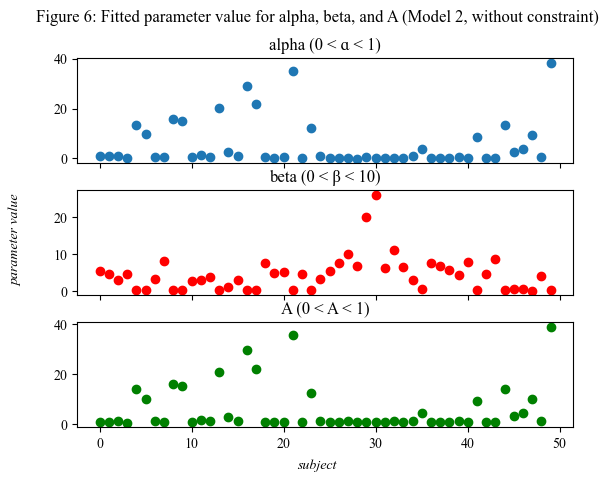

In [266]:
fig, ax = plt.subplots(3, sharex=True)
fig.suptitle('Figure 6: Fitted parameter value for alpha, beta, and A (Model 2, without constraint)')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha_alt)
ax[0].set_title('alpha (0 < ɑ < 1)')
ax[1].scatter(np.arange(0,50,1),fitted_beta_alt, color = 'red')
ax[1].set_title('beta (0 < β < 10)')
ax[2].scatter(np.arange(0,50,1),fitted_a_alt, color = 'green')
ax[2].set_title('A (0 < A < 1)')

Text(0.5, 1.0, 'A (0 < A < 1)')

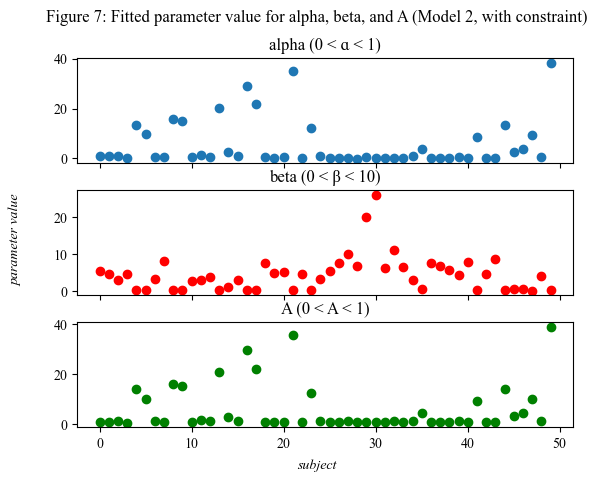

In [267]:
fig, ax = plt.subplots(3, sharex=True)
fig.suptitle('Figure 7: Fitted parameter value for alpha, beta, and A (Model 2, with constraint)')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_alpha_alt)
ax[0].set_title('alpha (0 < ɑ < 1)')
ax[1].scatter(np.arange(0,50,1),fitted_beta_alt, color = 'red')
ax[1].set_title('beta (0 < β < 10)')
ax[2].scatter(np.arange(0,50,1),fitted_a_alt, color = 'green')
ax[2].set_title('A (0 < A < 1)')

### Model comparison

In [268]:
# Compare the negative log likelihood values between the two models
# For each participant, compute AIC and BIC scores for each model


def AIC(nll,p):
    return 2*nll+2*p

def BIC(nll,p):
    return 2*nll+p*np.ma.log(160)

p1 = 2
p2 = 3
nll_list = []
nll_alt_list = []
AIC_list = []
AIC_alt_list = []
BIC_list = []
BIC_alt_list = []
for i in range(50):
    nll_list.append(nll([0.4,7],inst_choices[i],inst_outcomes[i],0.5))
    nll_alt_list.append(nll_alt([0.5,0.4,7],inst_choices[i],inst_outcomes[i],0.5))
    AIC_list.append(AIC(nll_list[i],p1))
    AIC_alt_list.append(AIC(nll_alt_list[i],p2))
    BIC_list.append(BIC(nll_list[i],p1))
    BIC_alt_list.append(BIC(nll_alt_list[i],p2))

print(nll_list)
print(nll_alt_list)
print(np.sum(AIC_list))
print(np.sum(AIC_alt_list))
print(np.sum(BIC_list))
print(np.sum(BIC_alt_list))

[71.89501709469803, 73.99902852070569, 63.48782166698683, 101.6050206224349, 52.68861467295329, 49.57025421866699, 51.67640689447347, 45.83387519851256, 60.877333438783324, 96.87827871571137, 121.82979052419863, 55.29336425971195, 45.302956732572476, 89.96392053484107, 69.0933773743769, 49.75817622629023, 61.54695515722878, 59.49679091453134, 40.11875819260712, 88.01597053519866, 61.01663621129176, 48.3936151673412, 74.3030016861751, 67.12210773918608, 38.78085225784171, 78.6687645503986, 45.88392040154698, 14.90590504976406, 68.62440500070787, 14.216069440154536, 22.19957601403611, 61.98829560327881, 24.47260689318613, 57.10556070235257, 39.12374571586506, 75.054059133254, 82.86536965051516, 63.258209037338545, 77.92305108365144, 35.92353527738445, 70.25209035730177, 62.85353933223457, 73.12094788753735, 59.81012524236908, 71.10489274283533, 69.4479720246508, 40.93620401075032, 145.89307779287049, 60.93348773619517, 46.915889434129014]
[52.203947410800026, 55.099495389326734, 58.26546

### Model recovery and confusion matrix

In [269]:
nn = 50
outcome_m = np.zeros([n,160])
choice_m = np.zeros([n,160])
outcome_m_alt = np.zeros([n,160])
choice_m_alt = np.zeros([n,160])

for i in range(nn):
    outcome_m[i] = outcome(0.4,7,prob_list,0.5)[0]
    choice_m[i] = outcome(0.4,7,prob_list,0.5)[1]
    outcome_m_alt[i] = outcome_alt(0.5,0.4,5,prob_list,0.5)[0]
    choice_m_alt[i] = outcome_alt(0.5,0.4,5,prob_list,0.5)[1]

In [270]:
p1 = 2
p2 = 3
nll_list_m = []
nll_alt_list_m = []
AIC_list_m = []
AIC_alt_list_m = []
BIC_list_m = []
BIC_alt_list_m = []

nll_list_m1 = []
nll_alt_list_m1 = []
AIC_list_m1 = []
AIC_alt_list_m1 = []
BIC_list_m1 = []
BIC_alt_list_m1 = []

for i in range(50):
    nll_list_m.append(nll([0.4,7],choice_m[i],outcome_m[i],0.5))
    nll_alt_list_m.append(nll_alt([0.5,0.4,7],choice_m[i],outcome_m[i],0.5))
    AIC_list_m.append(AIC(nll_list_m[i],p1))
    AIC_alt_list_m.append(AIC(nll_alt_list_m[i],p2))
    BIC_list_m.append(BIC(nll_list_m[i],p1))
    BIC_alt_list_m.append(BIC(nll_alt_list_m[i],p2))

    nll_list_m1.append(nll([0.4,7],choice_m_alt[i],outcome_m_alt[i],0.5))
    nll_alt_list_m1.append(nll_alt([0.5,0.4,7],choice_m_alt[i],outcome_m_alt[i],0.5))
    AIC_list_m1.append(AIC(nll_list_m1[i],p1))
    AIC_alt_list_m1.append(AIC(nll_alt_list_m1[i],p2))
    BIC_list_m1.append(BIC(nll_list_m1[i],p1))
    BIC_alt_list_m1.append(BIC(nll_alt_list_m1[i],p2))

print(np.sum(AIC_list_m))
print(np.sum(AIC_alt_list_m))
print(np.sum(BIC_list_m))
print(np.sum(BIC_alt_list_m))

print(np.sum(AIC_list_m1))
print(np.sum(AIC_alt_list_m1))
print(np.sum(BIC_list_m1))
print(np.sum(BIC_alt_list_m1))

15025.191471074295
13512.652071364038
15332.708852597678
13973.928143649115
12510.44003285552
11089.268885177486
12817.957414378903
11550.54495746256


### Discussion and extra model

In [271]:
def outcome_ex(ap,an,b,p,V0):
    
    outcome = np.zeros(160)
    choice = []
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice.append(np.random.choice([0,1],p=[p_a,p_b]))
        if choice[-1] == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(value_a[-1]+((1-outcome[i])*ap+outcome[i]*an)*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(value_b[-1]+((1-outcome[i])*ap+outcome[i]*an)*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, choice, value_a, value_b, sum(outcome)

def nll_ex(params, choices, outcome, V0):
    value_a = [V0]
    value_b = [V0]
    p_a = []
    c_a = np.zeros(len(choices))
    c_a[np.where(choices==1)] = 1
    c_b = np.zeros(len(choices))
    c_b[np.where(choices==2)] = 1
    ll = 0
    ap, an, b = params

    for i in range(len(choices)):
        if choices[i] == 1:
            value_a.append(value_a[-1]+((1-outcome[i])*ap+outcome[i]*an)*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            value_b.append(value_b[-1]+((1-outcome[i])*ap+outcome[i]*an)*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

        p_a.append(np.ma.exp(-b*(value_a[i]))*(np.ma.exp(-b*(value_a[i]))+np.ma.exp(-b*(value_b[i])))**(-1))
        ll -= ((np.ma.log(p_a[-1])*c_a[i]) + (np.ma.log((1-p_a[-1]))*c_b[i]))

    return ll


bounds = ((0,1),(0,1),(0,10))

fitted_param_ex = []
for i in range(len(stai_scores)):
    fitted_param_ex.append(sp.optimize.minimize(nll_ex,x0=(0.25,0.5,6), args=(inst_choices[i],inst_outcomes[i],0.5),method='Nelder-Mead', bounds = bounds).x)
fitted_ap_ex, fitted_an_ex, fitted_beta_ex = np.array(fitted_param_ex).T

Text(0.5, 1.0, 'beta')

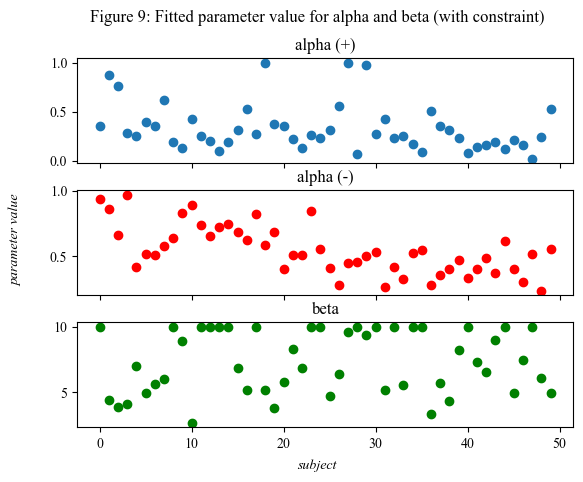

In [272]:
fig, ax = plt.subplots(3, sharex=True)
fig.suptitle('Figure 9: Fitted parameter value for alpha and beta (with constraint)')
fig.text(0.5, 0.03, 'subject', horizontalalignment ='center', verticalalignment = 'center', fontstyle = 'italic')
fig.text(0.03, 0.5, 'parameter value', horizontalalignment ='center', verticalalignment = 'center', rotation = 'vertical', fontstyle = 'italic')
fig.subplots_adjust(hspace = 0.25)
ax[0].scatter(np.arange(0,50,1),fitted_ap_ex)
ax[0].set_title('alpha (+)')
ax[1].scatter(np.arange(0,50,1),fitted_an_ex, color = 'red')
ax[1].set_title('alpha (-)')
ax[2].scatter(np.arange(0,50,1),fitted_beta_ex, color = 'green')
ax[2].set_title('beta')

In [273]:
print(sp.stats.ttest_ind(fitted_ap_ex[:25], fitted_ap_ex[25:],equal_var=False))
print(sp.stats.ttest_ind(fitted_an_ex[:25], fitted_an_ex[25:],equal_var=False))
print(sp.stats.ttest_ind(fitted_beta_ex[:25], fitted_beta_ex[25:],equal_var=False))

print(np.mean(fitted_an_ex[:25]))
print(np.mean(fitted_an_ex[25:]))

Ttest_indResult(statistic=0.8619068384825213, pvalue=0.3930480785659023)
Ttest_indResult(statistic=6.796807499245872, pvalue=3.107958313010415e-08)
Ttest_indResult(statistic=-0.5233537098985926, pvalue=0.6031603092790152)
0.6762895118972989
0.41897380104088966


In [274]:
nll_list_ex = []
AIC_ex = []
BIC_ex = []
for i in range(50):
    nll_list_ex.append(nll_ex([0.25,0.5,6],inst_choices[i],inst_outcomes[i],0.5))
    AIC_ex.append(AIC(nll_list_ex[i],p2))
    BIC_ex.append(BIC(nll_list_ex[i],p2))
print(np.sum(AIC_ex))
print(np.sum(BIC_ex))

6055.809202083026
6517.085274368101


In [275]:
outcome_m_ex = np.zeros([n,160])
choice_m_ex = np.zeros([n,160]) 

for i in range(nn):
    outcome_m_ex[i] = outcome_ex(0.25,0.5,6,prob_list,0.5)[0]
    choice_m_ex[i] = outcome_ex(0.25,0.5,6,prob_list,0.5)[1]

p2 = 3
nll_ex_list_m = []
AIC_ex_list_m = []
BIC_ex_list_m = []

for i in range(50):
    nll_ex_list_m.append(nll_ex([0.25,0.5,6],choice_m_ex[i],outcome_m_ex[i],0.5))
    AIC_ex_list_m.append(AIC(nll_ex_list_m[i],p2))
    BIC_ex_list_m.append(BIC(nll_ex_list_m[i],p2))

print(np.sum(AIC_ex_list_m))
print(np.sum(BIC_ex_list_m))

13177.304146106908
13638.58021839198


In [276]:
p1 = 2
p2 = 3
nll_list_m = []
nll_alt_list_m = []
nll_ex_list_m = []
AIC_list_m = []
AIC_alt_list_m = []
BIC_list_m = []
BIC_alt_list_m = []
AIC_ex_list_m = []
BIC_ex_list_m = []

nll_list_m1 = []
nll_alt_list_m1 = []
nll_ex_list_m1 = []
AIC_list_m1 = []
AIC_alt_list_m1 = []
BIC_list_m1 = []
BIC_alt_list_m1 = []
AIC_ex_list_m1 = []
BIC_ex_list_m1 = []

nll_list_m2 = []
nll_alt_list_m2 = []
nll_ex_list_m2 = []
AIC_list_m2 = []
AIC_alt_list_m2 = []
BIC_list_m2 = []
BIC_alt_list_m2 = []
AIC_ex_list_m2 = []
BIC_ex_list_m2 = []

for i in range(50):
    nll_list_m.append(nll([0.4,7],choice_m[i],outcome_m[i],0.5))
    nll_alt_list_m.append(nll_alt([0.5,0.4,7],choice_m[i],outcome_m[i],0.5))
    nll_ex_list_m.append(nll_ex([0.25,0.5,6],choice_m[i],outcome_m[i],0.5))
    AIC_list_m.append(AIC(nll_list_m[i],p1))
    AIC_alt_list_m.append(AIC(nll_alt_list_m[i],p2))
    AIC_ex_list_m.append(AIC(nll_ex_list_m[i],p2))
    BIC_list_m.append(BIC(nll_list_m[i],p1))
    BIC_alt_list_m.append(BIC(nll_alt_list_m[i],p2))
    BIC_ex_list_m.append(BIC(nll_ex_list_m[i],p2))

    nll_list_m1.append(nll([0.4,7],choice_m_alt[i],outcome_m_alt[i],0.5))
    nll_alt_list_m1.append(nll_alt([0.5,0.4,7],choice_m_alt[i],outcome_m_alt[i],0.5))
    nll_ex_list_m1.append(nll_ex([0.25,0.5,6],choice_m_alt[i],outcome_m_alt[i],0.5))
    AIC_list_m1.append(AIC(nll_list_m1[i],p1))
    AIC_alt_list_m1.append(AIC(nll_alt_list_m1[i],p2))
    AIC_ex_list_m1.append(AIC(nll_ex_list_m1[i],p2))
    BIC_list_m1.append(BIC(nll_list_m1[i],p1))
    BIC_alt_list_m1.append(BIC(nll_alt_list_m1[i],p2))
    BIC_ex_list_m1.append(BIC(nll_ex_list_m1[i],p2))

    nll_list_m2.append(nll([0.4,7],choice_m_ex[i],outcome_m_ex[i],0.5))
    nll_alt_list_m2.append(nll_alt([0.5,0.4,7],choice_m_ex[i],outcome_m_ex[i],0.5))
    nll_ex_list_m2.append(nll_ex([0.25,0.5,6],choice_m_ex[i],outcome_m_ex[i],0.5))
    AIC_list_m2.append(AIC(nll_list_m2[i],p1))
    AIC_alt_list_m2.append(AIC(nll_alt_list_m2[i],p2))
    AIC_ex_list_m2.append(AIC(nll_ex_list_m2[i],p2))
    BIC_list_m2.append(BIC(nll_list_m2[i],p1))
    BIC_alt_list_m2.append(BIC(nll_alt_list_m2[i],p2))
    BIC_ex_list_m2.append(BIC(nll_ex_list_m2[i],p2))


print(np.sum(AIC_list_m))
print(np.sum(AIC_alt_list_m))
print(np.sum(AIC_ex_list_m))
print(np.sum(BIC_list_m))
print(np.sum(BIC_alt_list_m))
print(np.sum(BIC_ex_list_m))
print('')
print(np.sum(AIC_list_m1))
print(np.sum(AIC_alt_list_m1))
print(np.sum(AIC_ex_list_m1))
print(np.sum(BIC_list_m1))
print(np.sum(BIC_alt_list_m1))
print(np.sum(BIC_ex_list_m1))
print('')
print(np.sum(AIC_list_m2))
print(np.sum(AIC_alt_list_m2))
print(np.sum(AIC_ex_list_m2))
print(np.sum(BIC_list_m2))
print(np.sum(BIC_alt_list_m2))
print(np.sum(BIC_ex_list_m2))

15025.191471074295
13512.652071364038
14311.575557501656
15332.708852597678
13973.928143649115
14772.851629786728

12510.44003285552
11089.268885177486
11096.96025033126
12817.957414378903
11550.54495746256
11558.236322616332

14770.13985509459
13351.963949455756
13177.304146106908
15077.657236617973
13813.24002174083
13638.58021839198


           Model 1 AIC (BIC)    Model 2 AIC (BIC)    Model 3 AIC (BIC)
Model 1  15025.19 (15332.71)  13512.65 (13973.93)  14311.58 (14772.85)
Model 2  12510.44 (12817.96)  11089.27 (11550.54)  11096.96 (11558.24)
Model 3  14770.14 (15077.66)  13351.96 (13813.24)   13177.3 (13638.58)


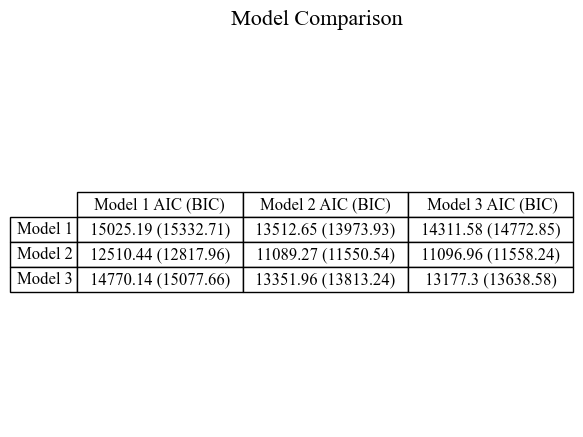

In [277]:
data = np.round([
    [15025.191471074295, 15332.708852597678, 13512.652071364038, 13973.928143649115, 14311.575557501656, 14772.851629786728],
    [12510.44003285552, 12817.957414378903, 11089.268885177486, 11550.54495746256, 11096.96025033126, 11558.236322616332],
    [14770.13985509459, 15077.657236617973, 13351.963949455756, 13813.24002174083, 13177.304146106908, 13638.58021839198]], 2)

combined_data = []

for row in data:
    combined_row = [f"{row[0]} ({row[1]})", f"{row[2]} ({row[3]})", f"{row[4]} ({row[5]})"]
    combined_data.append(combined_row)

df = pd.DataFrame(combined_data)

# Optionally, you can set column names and index labels
column_names = ['Model 1 AIC (BIC)', 'Model 2 AIC (BIC)', ' Model 3 AIC (BIC)']
index_labels = ['Model 1', 'Model 2', 'Model 3']

df.columns = column_names
df.index = index_labels

print(df)

df.columns = column_names
df.index = index_labels

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)
fig.suptitle("Model Comparison", fontsize=16)
ax.set_ylabel("Y-Axis Label", fontsize=14, labelpad=20, rotation=0, va='center')


plt.show()

[[ 2 25 23]
 [ 2 22 26]
 [ 1 19 30]]


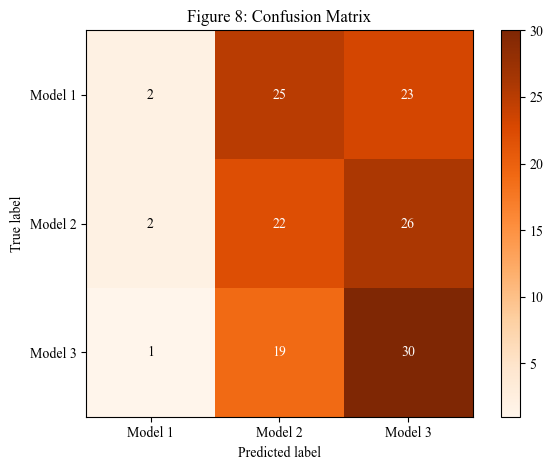

In [278]:
true_labels = [0,1,2]*50

predicted_labels = []
for i in range(50):
    aic_m = [AIC_list_m[i], AIC_alt_list_m[i], AIC_ex_list_m[i]]
    aic_m1 = [AIC_list_m1[i], AIC_alt_list_m1[i], AIC_ex_list_m1[i]]
    aic_m2 = [AIC_list_m2[i], AIC_alt_list_m2[i], AIC_ex_list_m2[i]]

    predicted_labels.extend([np.argmin(aic_m), np.argmin(aic_m1), np.argmin(aic_m2)])

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
confusion_matrix = np.array([[2, 25, 23], [2, 22, 26], [1, 19, 30]])

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Oranges)
ax.figure.colorbar(im, ax=ax)

# Set the labels for the confusion matrix
labels = ['Model 1', 'Model 2', 'Model 3']
ax.set(xticks=np.arange(confusion_matrix.shape[1]),
       yticks=np.arange(confusion_matrix.shape[0]),
       xticklabels=labels, yticklabels=labels,
       title="Figure 8: Confusion Matrix",
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

fig.tight_layout()
plt.show()
# The confusion matrix suggests that Model 1 has the lowest correct identification rate, 
# while Model 3 has the highest correct identification rate. Model 2 has an intermediate 
# correct identification rate. It appears that the AIC-based model selection method struggles 
# to distinguish Model 1 from the other two models, while it does a better job of identifying Model 2 and Model 3.